In [1]:
import shap
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import contextlib

Matplotlib created a temporary cache directory at /JOBs/tmpdir/pbs.12660557.spcc-adm1/matplotlib-ffcyvssh because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-02-12 14:24:57.138033: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 14:24:57.140949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 14:24:57.176749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alre

In [3]:
tf.__version__

'2.14.0'

In [2]:
# Load test set for generating explanations using SHAP
test_dataset = tf.data.Dataset.load('test_dataset')
test_dataset = test_dataset.shuffle(64)

2025-02-12 14:25:00.468306: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 1. Models with different feature extractors

In [3]:
# Load the models
model_extrcs = []
saved_dir    = "models/diff_extrcs"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_extrcs.append(model)

In [6]:
for model_file in model_extrcs:
    print(model_file.name)

MobileNetV2_MNIST
CNN_MNIST
Densenet121-MNIST
EfficientNet-MNIST


(64, 32, 32, 3)
(64, 10)
Normalized values:  (0.0, 0.99583334)


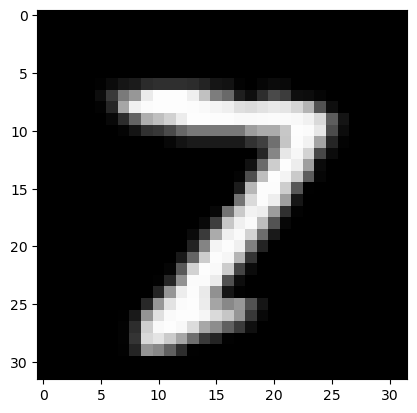

In [8]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img = np.array(img_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])

### debugging

In [9]:
model    = model_extrcs[0]
instance = img[0].reshape(-1,32,32,3)
pred     = model.predict(instance)
print(np.argmax(pred))

1/1 [==============================] - 0s 32ms/step
7


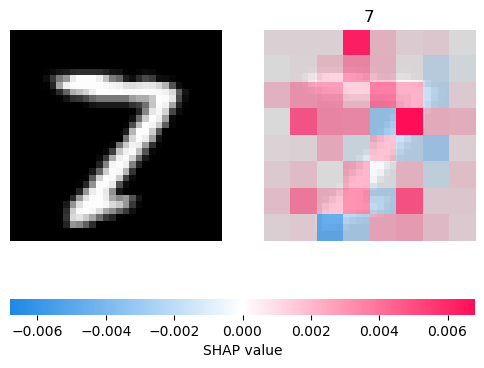

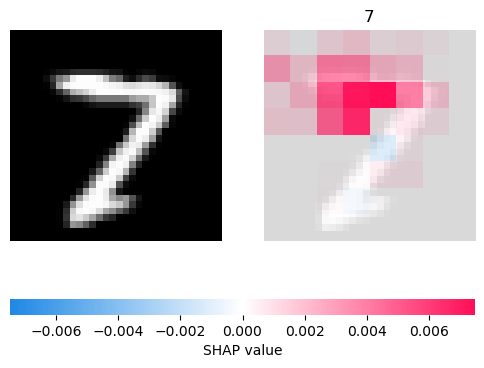

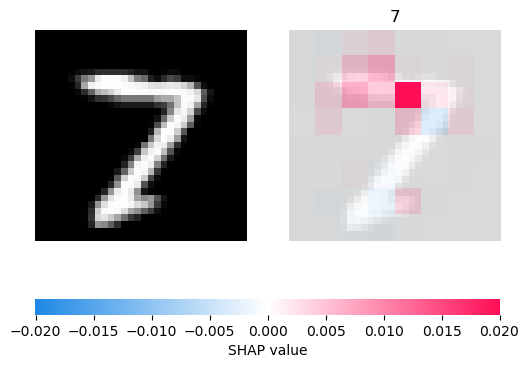

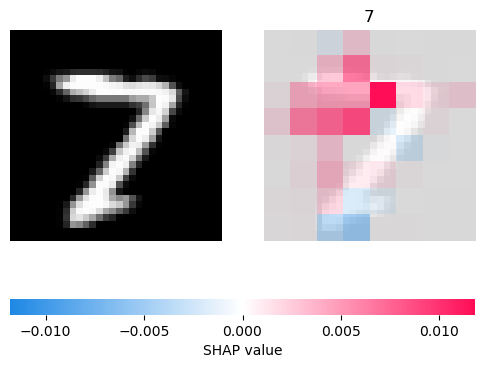

In [17]:
from tools import SHAPExplainer

shap_explainer = SHAPExplainer()

for model in model_extrcs:
    shap_value = shap_explainer.explain_aninstance(img[0], model)
    shap.image_plot(shap_value)

In [13]:
import helper_functions

sample_lists    = [helper_functions.get_sample(i, test_dataset) for i in range(10)]

In [14]:
preds_encods    = [helper_functions.get_predictions(model_extrcs, sample_list) for sample_list in sample_lists]
newlists_encods = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_encods]

Wrong Prediction at index 53 by MobileNetV2_MNIST: Predicted [6], True 0
Wrong Prediction at index 155 by MobileNetV2_MNIST: Predicted [2], True 0
Wrong Prediction at index 192 by Densenet121-MNIST: Predicted [6], True 1
Wrong Prediction at index 214 by MobileNetV2_MNIST: Predicted [8], True 1
Wrong Prediction at index 32 by EfficientNet-MNIST: Predicted [1], True 2
Wrong Prediction at index 36 by EfficientNet-MNIST: Predicted [3], True 2
Wrong Prediction at index 50 by MobileNetV2_MNIST: Predicted [8], True 2
Wrong Prediction at index 87 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 186 by CNN_MNIST: Predicted [7], True 2
Wrong Prediction at index 93 by MobileNetV2_MNIST: Predicted [5], True 3
Wrong Prediction at index 183 by CNN_MNIST: Predicted [7], True 3
Wrong Prediction at index 185 by Densenet121-MNIST: Predicted [8], True 3
Wrong Prediction at index 29 by CNN_MNIST: Predicted [9], True 4
Wrong Prediction at index 53 by CNN_MNIST: Predicted [9], True 4
Wrong Pred

### Generate explanations

In [15]:
%%time

save_directory = 'shap_expls/diff_extrcs'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        shap_explainer.generate_and_save_explanations(newlists_encods, model_extrcs, save_directory)

CPU times: user 20h 3min 11s, sys: 2h 57min 18s, total: 23h 30s
Wall time: 4h 13min 24s


## 2. Models with different optimizers

In [16]:
model_opts = []
saved_dir  = "models/diff_opts"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_opts.append(model)

In [17]:
for model in model_opts:
    print(model.name)

CNN-MNIST-Adam
CNN_MNIST-SGD
CNN-MNIST-RMSprop
CNN-MNIST-Nadam


In [18]:
# filter out wrong predictions
preds_opts    = [helper_functions.get_predictions(model_opts, sample_list) for sample_list in sample_lists]
newlists_opts = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_opts]

Wrong Prediction at index 42 by CNN-MNIST-Nadam: Predicted [2], True 0
Wrong Prediction at index 138 by CNN-MNIST-Nadam: Predicted [8], True 0
Wrong Prediction at index 155 by CNN-MNIST-RMSprop: Predicted [7], True 0
Wrong Prediction at index 50 by CNN-MNIST-Nadam: Predicted [8], True 2
Wrong Prediction at index 63 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 87 by CNN-MNIST-RMSprop: Predicted [7], True 2
Wrong Prediction at index 186 by CNN_MNIST-SGD: Predicted [7], True 2
Wrong Prediction at index 195 by CNN-MNIST-RMSprop: Predicted [8], True 2
Wrong Prediction at index 93 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 144 by CNN_MNIST-SGD: Predicted [5], True 3
Wrong Prediction at index 29 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong Prediction at index 53 by CNN-MNIST-Adam: Predicted [9], True 4
Wrong Prediction at index 89 by CNN_MNIST-SGD: Predicted [6], True 4
Wrong Prediction at index 97 by CNN_MNIST-SGD: Predicted [9], True 4
Wrong 

### Generate explanations

In [19]:
save_directory = 'shap_expls/diff_opts'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        shap_explainer.generate_and_save_explanations(newlists_opts, model_opts, save_directory)

## 3. Models with different weight initialization

In [20]:
model_seeds = []
saved_dir    = "models/diff_seeds"

for model_file in os.listdir(saved_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(saved_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

In [21]:
for i, model in enumerate(model_seeds):
    model._name = f"CNN{i+1}"
    print(model.name)

CNN1
CNN2
CNN3
CNN4
CNN5
CNN6
CNN7
CNN8
CNN9
CNN10


In [22]:
# filter out wrong predictions
preds_seeds    = [helper_functions.get_predictions(model_seeds, sample_list) for sample_list in sample_lists]
newlists_seeds = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_seeds]

Wrong Prediction at index 42 by CNN1: Predicted [2], True 0
Wrong Prediction at index 53 by CNN5: Predicted [6], True 0
Wrong Prediction at index 138 by CNN2: Predicted [6], True 0
Wrong Prediction at index 155 by CNN2: Predicted [6], True 0
Wrong Prediction at index 2 by CNN3: Predicted [7], True 2
Wrong Prediction at index 63 by CNN3: Predicted [7], True 2
Wrong Prediction at index 69 by CNN3: Predicted [7], True 2
Wrong Prediction at index 87 by CNN5: Predicted [7], True 2
Wrong Prediction at index 186 by CNN3: Predicted [7], True 2
Wrong Prediction at index 195 by CNN9: Predicted [8], True 2
Wrong Prediction at index 93 by CNN2: Predicted [5], True 3
Wrong Prediction at index 144 by CNN2: Predicted [5], True 3
Wrong Prediction at index 183 by CNN10: Predicted [7], True 3
Wrong Prediction at index 29 by CNN6: Predicted [9], True 4
Wrong Prediction at index 50 by CNN3: Predicted [1], True 4
Wrong Prediction at index 53 by CNN3: Predicted [9], True 4
Wrong Prediction at index 89 by CN

### Generate explanation

In [23]:
%%time
save_directory = 'shap_expls/diff_seeds'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        SHAP.generate_and_save_explanations(newlists_seeds, model_seeds, save_directory)

CPU times: user 10h 49min 32s, sys: 1h 37s, total: 11h 50min 10s
Wall time: 6h 22min 55s
